# MineCraft **旅行的时光**成就的最短路径

In [1]:
from PIL import Image
import numpy as np
from collections import defaultdict

image = Image.open('src/map.ppm')
image = np.array(image)
width, height = image.shape[:2]

colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)

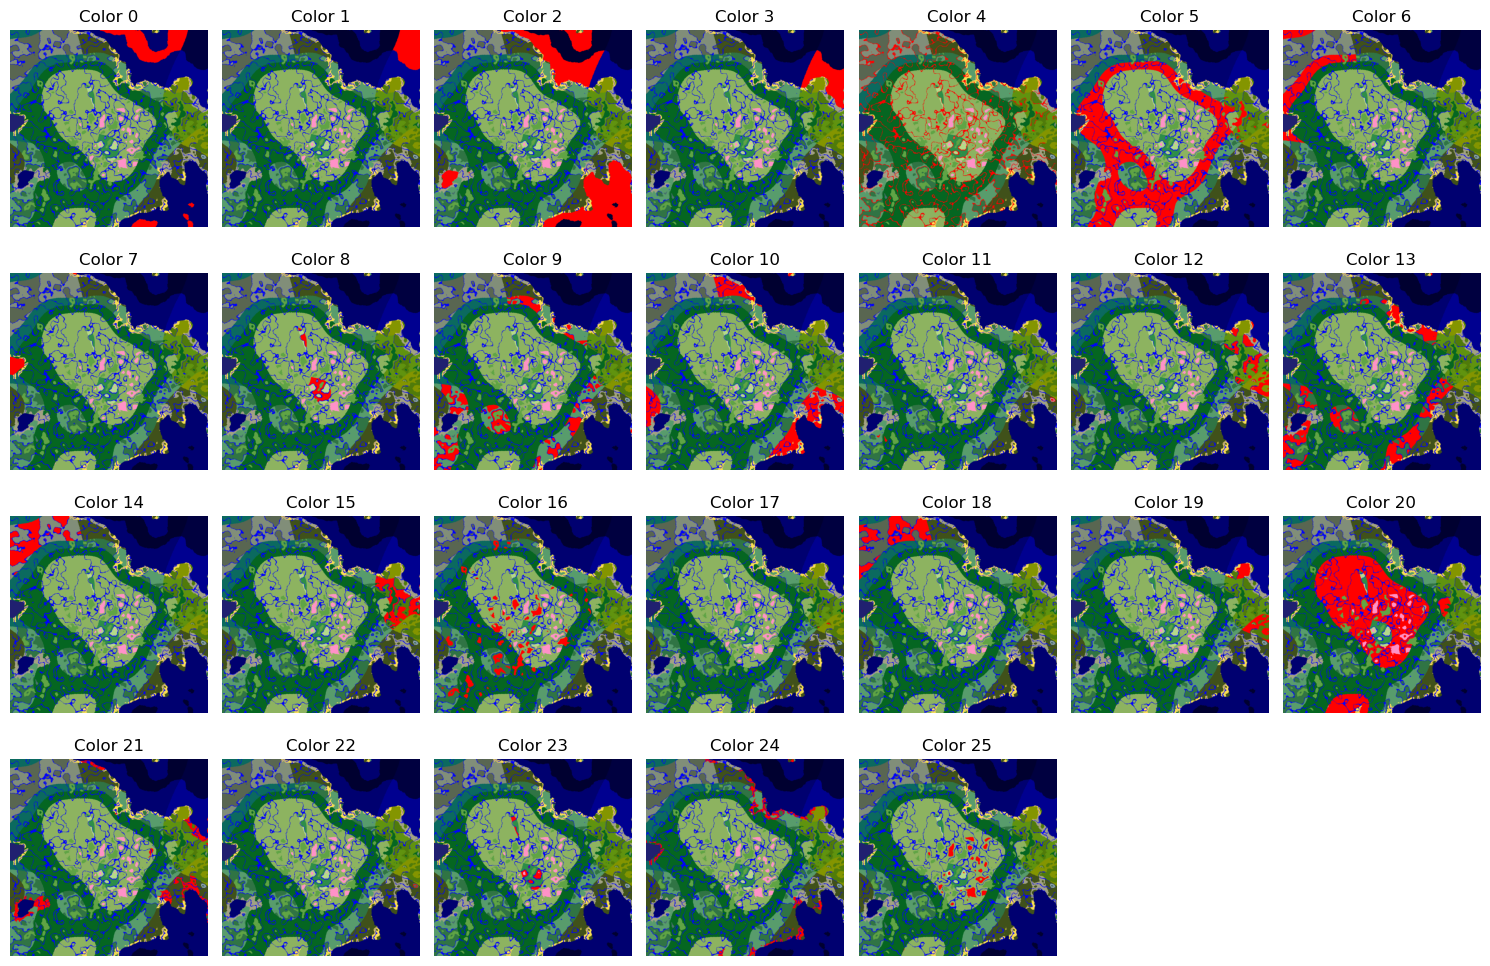

In [2]:
import matplotlib.pyplot as plt

def mark_color(image, color):
    image_marked = np.copy(image)
    image_marked[np.where((image == color).all(axis=2))] = [255, 0, 0]
    return image_marked

fig, ax = plt.subplots(len(colors) // 7 + 1, 7, figsize=(15, 10))
ax = ax.ravel()
for i, color in enumerate(colors):
    ax[i].imshow(mark_color(image, color))
    ax[i].set_title(f'Color {i}')
    ax[i].axis('off')

for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)  # 将多余的子图隐藏
    
plt.tight_layout()
plt.show()

可视化不同生物群系的常见程度，以及在不同生物群系之间的旅行成本。

常见程度 $C(i)$ 的定义是：在给定区域内离群系 $i$ 的曼哈顿距离小于等于 $d_\text{lim}$ 的区块数占总区块数的比例。结合生物群系分布的特性，我们首先进行 K-Means 聚类，然后计算每个聚类的常见程度。

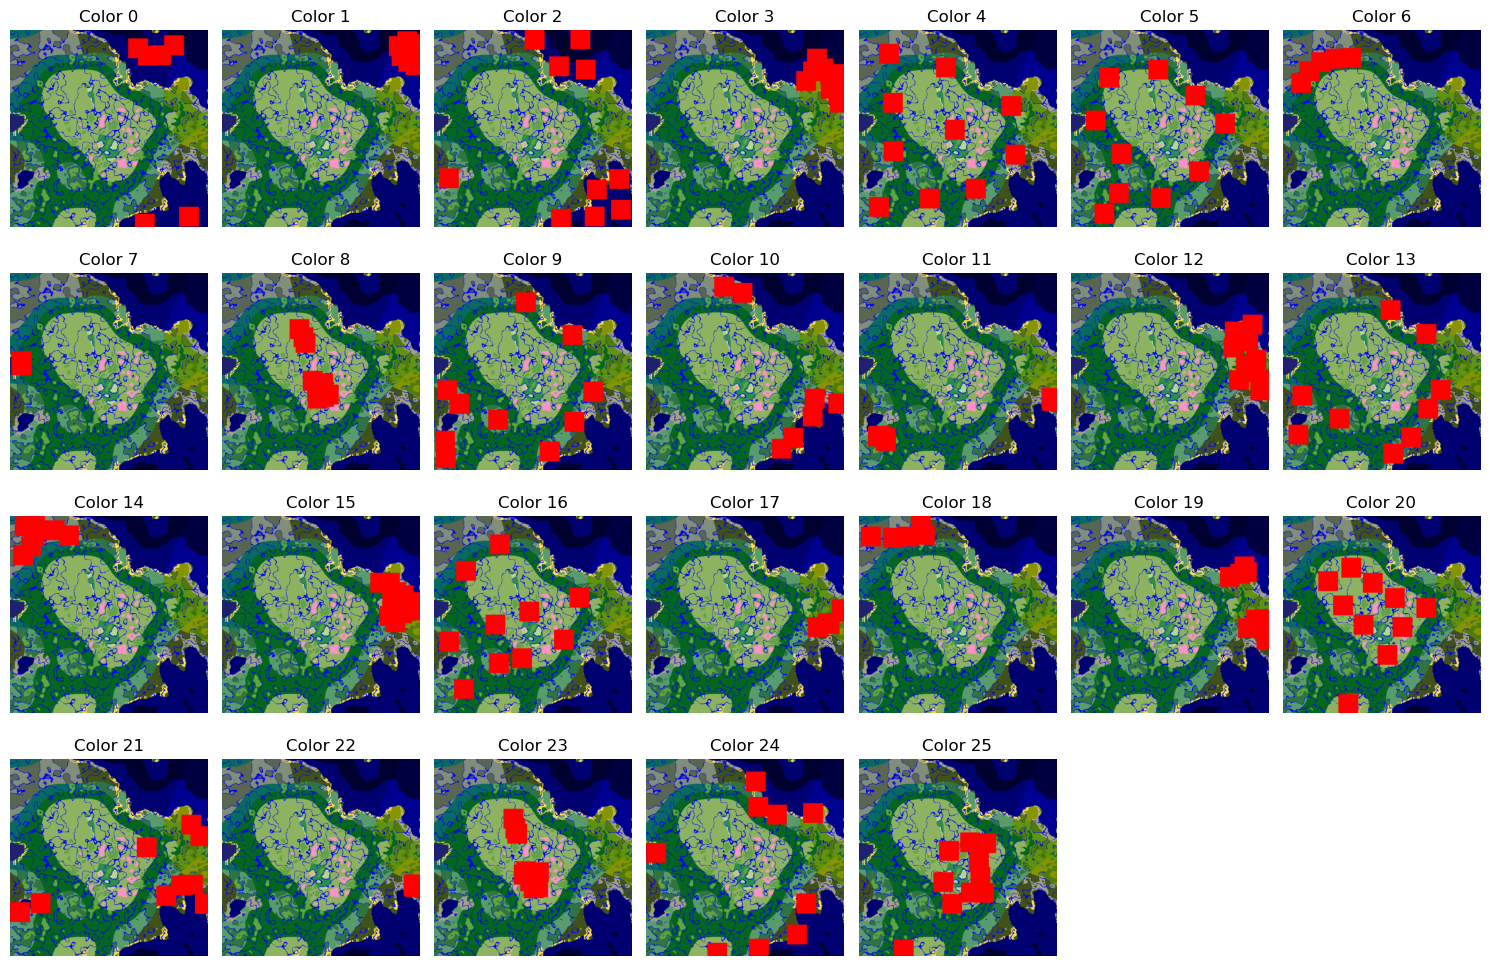

In [26]:
from sklearn.cluster import KMeans
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')

# 假设 image 是一个 numpy 数组，包含图像数据
# 假设 colors 是一个颜色列表，其中每个颜色是一个 (R, G, B) 元组
# 假设 d_lim 是距离限制

d_lim = 100
common_factors = []

height, width, _ = image.shape
fig, ax = plt.subplots(len(colors) // 7 + 1, 7, figsize=(15, 10))
ax = ax.ravel()

# 优化的算法，使用 k-means 聚类
for i, color in tqdm(enumerate(colors), leave=False, total=len(colors)):

    # 找到所有匹配该颜色的像素点
    color_range = np.where((image == color).all(axis=2))
    if color_range[0].size == 0:
        continue

    # 将像素点位置转换为聚类所需的数据格式
    pixel_positions = np.column_stack(color_range)

    # 使用 k-means 聚类
    k = min(10, len(pixel_positions) // 100)  # 动态确定 k 值
    if k == 0:
        continue
    kmeans = KMeans(n_clusters=k).fit(pixel_positions)
    clusters = kmeans.cluster_centers_

    # 创建一个空的遮罩
    mask = np.zeros((height, width), dtype=int)

    # 更新遮罩
    for cluster in clusters:
        x, y = cluster
        x_min, x_max = int(x) - d_lim, int(x) + d_lim
        y_min, y_max = int(y) - d_lim, int(y) + d_lim
        mask[x_min:x_max, y_min:y_max] = 1

    # 计算遮罩中被标记的像素点占整个图像的比例
    factor = np.sum(mask) / (height * width)
    common_factors.append(factor)

    # 显示遮罩区域
    red_color = np.array([255, 0, 0])
    masked_image = np.where(mask[..., None] == 1, red_color, image)
    ax[i].imshow(masked_image)
    ax[i].set_title(f'Color {i}')
    ax[i].axis('off')

for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)  # 将多余的子图隐藏
plt.tight_layout()
plt.show()

可视化不同群系的常见程度。可见差别是相当大的，这意味着可以优先满足稀有群系的访问，然后在常见群系中进一步优化路径。

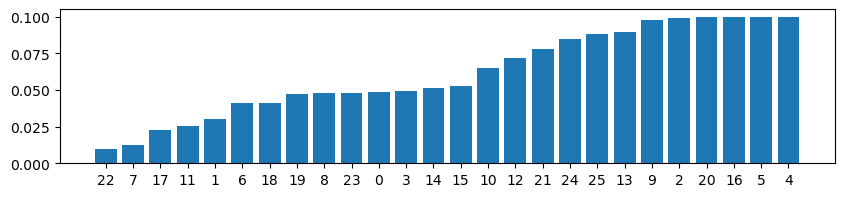

In [27]:
fig = plt.figure(figsize=(10, 2))
x = np.arange(len(colors))
order = np.argsort(common_factors)
plt.bar(order, np.sort(common_factors)[order])
plt.xticks(x, order)
plt.show()